### Solar Radiation Pressure: Various contributions

In this example we will compute the solar radiation pressure on a simple object and analyze the different contributions
- Specular reflection
- Secondary specular reflection
- Diffusion

In [1]:
from pyRTX.classes.Spacecraft import Spacecraft
from pyRTX.classes.RayTracer import RayTracer
from pyRTX.classes.PixelPlane import PixelPlane
from pyRTX.classes.SRP import SolarPressure
from pyRTX.core.analysis_utils import get_spacecraft_area
from pyRTX.visual.utils import plot_mesh
import trimesh as tm
import numpy as np
import matplotlib.pyplot as plt

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': '3D Mesh'}, xlabel='X', ylabel='Y', zlabel='Z'>)

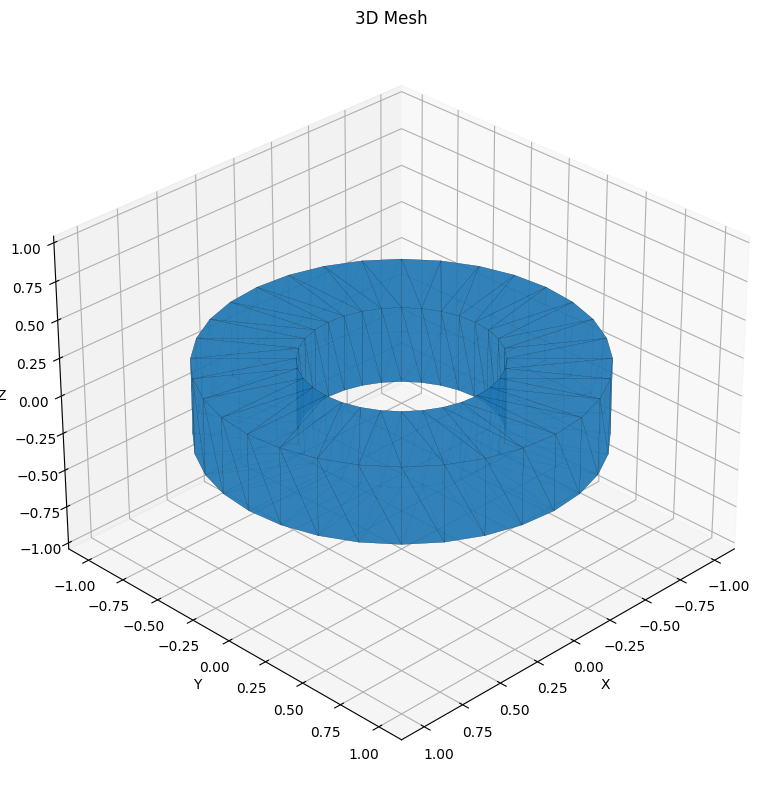

In [94]:
# Let's create a simple object that has an interesting shape for evaluating 
# advanced SRP effects
mesh = tm.creation.annulus(0.5,1,height = 0.5)
# mesh = tm.creation.icosphere()

# Define some basic information
flux = 1361 # W/m2
mass = 100


# Visualize the object
plot_mesh(mesh)

Let's now define a spaceraft object. 
The spacecraft uses the shape we have defined previously

In [95]:
sc = Spacecraft( 
            name = 'My Spacecraft',
            base_frame = 'SC Frame', # Name of the spacecraft body-fixed frame
            mass = mass, 
            units = 'm',
            spacecraft_model = { 
       
            
            'Bus': { 
                'file' : mesh,  # Note that you can also input directly a mesh (it must be trimesh.Trimesh object)
                'frame_type': 'UD', # type of frame (can be 'Spice' or 'UD'= User Defined)
                'UD_rotation' : tm.transformations.identity_matrix(), # If UD is chosen, the rotation matrix between the element and the base frame must be defined
                'frame_name': 'SC Bus', # Name of the frame
                'center': [0.0,0.0,0.0], # Origin of the component
                'diffuse': 0.1, # Diffuse reflect. coefficient
                'specular': 0.3, # Specular reflect. coefficient
                
                
            },
            },


                )


In this case we will use a fixed location for the pixel plane (i.e., the origin of the rays). 
We choose on purpose a direction that will likely generate reflections inside the annulus, so we'll be able to
assess the importance of secondary reflections

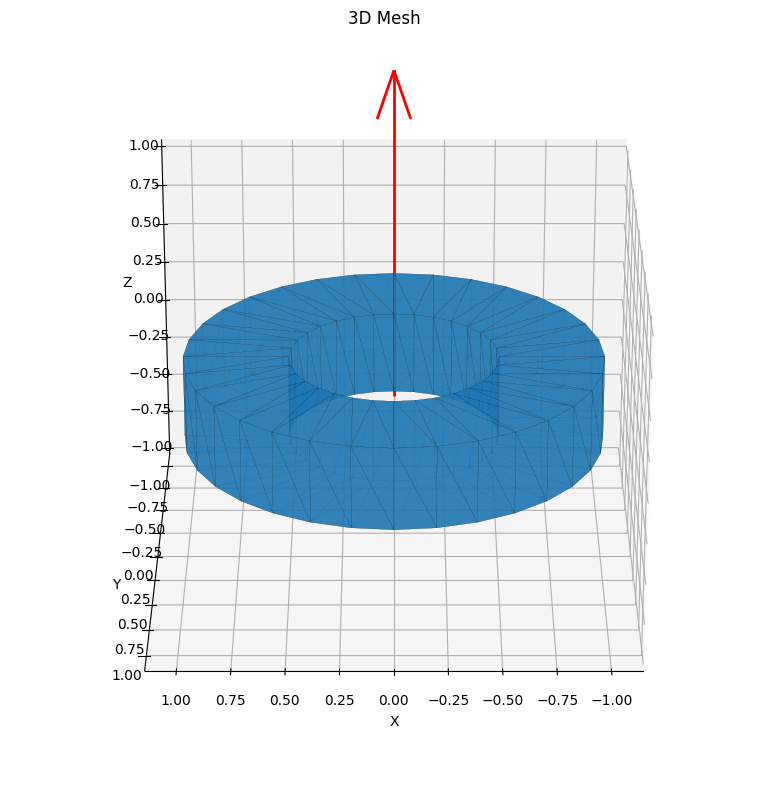

In [87]:
# Define the origin direction of the pixel plane in the spacecraft frame 
RA = 0 # rad
DEC = 90 * np.pi/180 #rad

# And visualize the direction
x = np.cos(DEC)*np.cos(RA)
y = np.cos(DEC)*np.sin(RA)
z = np.sin(DEC)
start_point = [0,0,0]
direction = 2*np.array([x,y,z])

fig, ax = plot_mesh(mesh, azim = 90, elev = 25)
ax.quiver(start_point[0], start_point[1], start_point[2],
          direction[0], direction[1], direction[2],
          color='red', arrow_length_ratio=0.15, linewidth=2, zorder = 10)


In [90]:
# Initialize the pixel plane
pixelPlane = PixelPlane(
        spacecraft = 'None',
        mode = 'Fixed',
        distance = 0.30,
        width = 0.2,
        height = 0.2,
        ray_spacing = 0.01,
        lon = RA,
        lat = DEC,
        units = 'km', 
)

# Initialize the ray-tracer explicitly requesting to compute
# up to the fourth bounce.
rtx = RayTracer(sc, 
                pixelPlane, 
                kernel = 'Embree', 
                bounces = 1, 
                diffusion = False, 
                num_diffuse = 10)


# Asking for grouped=False allows to retrieve
# the results for each bounce individually
# Note that in this case we have to set the baseflux to None
# this is because we don't have a real spacecraft
# so no trajectory is known for this object
# if we tried to set the baseflux to some value
# the solar pressure object would try to find
# the location of the spacecraft to rescale the flux
# at the correct distance
srp = SolarPressure(sc, rtx, 
                    baseflux = None,
                    grouped = False, 
                   
                   )
# This will raise a warning, because tupically this setting
# is used for computing a lookup table (LUT)
# (See more details in the LUT example)


 *** WARNING: For LUT computation SC mass should be set to 1.0!


In [91]:
rtx.trace(None)
rtx.ray_origins_container

No intersections found for bounce 1. Results provided up to bounce 0


[array([[ 0.1 , -0.1 ,  0.3 ],
        [ 0.09, -0.1 ,  0.3 ],
        [ 0.08, -0.1 ,  0.3 ],
        ...,
        [-0.08,  0.1 ,  0.3 ],
        [-0.09,  0.1 ,  0.3 ],
        [-0.1 ,  0.1 ,  0.3 ]])]

In [92]:
# To compute the acceleration we need to provide an epoch


accel = np.array(srp.compute([0], n_cores = 1)) * flux

print(accel)

No intersections found for bounce 1. Results provided up to bounce 0
[]


Found bounces 1


TypeError: only size-1 arrays can be converted to Python scalars

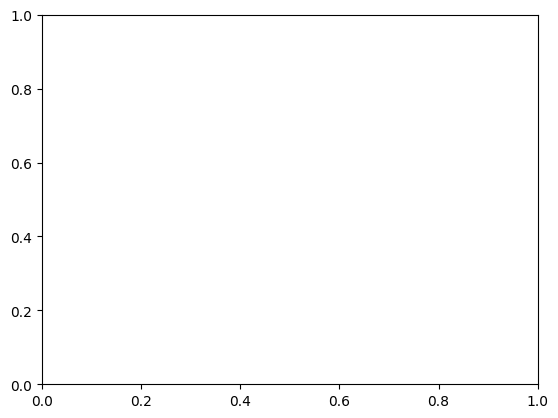

In [63]:
print(f'Found bounces {len(accel)}')

fig, ax = plt.subplots()
ax.bar(np.arange(1, len(accel)+1), np.linalg.norm(accel, axis = 1))
ax.set_yscale('log')
ax.set_ylabel('Acceleration [km/s2]')
ax.set_xlabel('Bounce number')
ax.set_xticks(np.arange(1, len(accel)+1));